In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mido
import numpy as np
import tensorflow as tf
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Flatten
from tensorflow.keras.models import Model

     |████████████████████████████████| 61kB 4.7MB/s 


In [3]:
note_duration = np.load('/content/drive/MyDrive/Major Project/paper/note_duration_final.npy')

In [ ]:
notes_with_times = [list(note) for note in note_duration]

X = []

# number of notes in a sequence
n_prev = 100

#for i in range(0, len(notes_with_times)-n_prev, 10):
  #X.append(notes_with_times[i : i + n_prev])
  
for i in range(0, len(notes_with_times) - n_prev, n_prev):
  X.append(notes_with_times[i : i + n_prev])

X = np.array(X)
print(X.shape)

(7607, 100, 3)


In [ ]:
X = np.array(X)
print(X[0,22,:])
print(X.shape)
#np.random.shuffle(X)
print(X[0,22,:])
print(X.shape)

[74.     0.125  0.125]
(7607, 100, 3)
[74.     0.125  0.125]
(7607, 100, 3)


In [ ]:
def generator():
    gen_input = Input(shape = (None, 100))
    X = Dense(400, activation = "relu")(gen_input)
    X = LSTM(400, return_sequences = True)(X)
    X = LSTM(400, return_sequences = True)(X)
    out = Dense(3)(X)
    model = Model(inputs = gen_input, outputs = out)
    return model

In [ ]:
def discriminator():
    disc_input = Input(shape = (100, 3))
    X = LSTM(400, return_sequences = True)(disc_input)
    X = LSTM(400, return_sequences = True)(X)
    out = Dense(1, activation = "sigmoid")(X)
    model = Model(inputs = disc_input, outputs = out)
    return model

In [ ]:
def disc_with_gen(generator, discriminator):
    inputs = Input(shape = (None, 100))
    generated = generator(inputs)
    outputs = discriminator(generated)
    model = Model(inputs = inputs, outputs = outputs)
    return model

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD
#optimizer = SGD(lr = 0.03)
optimizer = Adam(0.0002, 0.5)
d = discriminator()
d.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
g = generator()

In [ ]:
d.trainable = False
combined = disc_with_gen(g, d)
combined.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
combined.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None, 100)]       0         
_________________________________________________________________
model_4 (Functional)         (None, None, 3)           2604803   
_________________________________________________________________
model_3 (Functional)         (None, 100, 1)            1928401   
Total params: 4,533,204
Trainable params: 2,604,803
Non-trainable params: 1,928,401
_________________________________________________________________


In [ ]:
len(disc_loss_epoch)

160

In [ ]:
X.shape

(7607, 100, 3)

In [ ]:
from matplotlib import pyplot as plt
assert not np.any(np.isnan(X))

In [ ]:
disc_loss = []
disc_loss_epoch = []
gen_loss = []
gen_loss_epoch = []

In [ ]:
batch_size = 16

In [ ]:
idx = list(range(0, batch_size, 1))
real_data = X[idx]
real_data.shape

(16, 100, 3)

In [ ]:
def train(epochs, num_of_batches, batch_size = batch_size):
    for epoch in range(epochs):
        a = 0
        b = batch_size
        for num in range(num_of_batches):
          idx = list(range(a, b, 1))
          real_data = X[idx]

          noise = np.random.normal(0, 1, (batch_size, 100, 100))

          generated = g.predict(noise)
          d_loss_real = d.train_on_batch(real_data, np.ones((batch_size, 1)))
          #print("d_loss_real: ", d_loss_real)
          d_loss_fake = d.train_on_batch(generated, np.zeros((batch_size, 1)))
          #print("d_loss_fake: ",d_loss_fake)
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          print("%d d_loss: " %epoch,d_loss)
            
          noise = np.random.normal(0, 1, (batch_size, 100, 100))
          g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))
          print("%d g_loss: " %epoch, g_loss)

          print("\n")

          disc_loss.append(d_loss[0])
          gen_loss.append(g_loss[0])

          a = a + batch_size
          b = b + batch_size
            
        if epoch % 1 == 0:
          print ("Epoch %d [D loss: %f, acc.: %.2f%%] [G loss: %f, acc.: %.2f%%]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], 100*g_loss[1]))
          print("\n")
          disc_loss_epoch.append(d_loss[0])
          gen_loss_epoch.append(g_loss[0])
          save_model()
          save_weights()
          save_losses()
          checkpoint = tf.train.Checkpoint(g)
          checkpoint.save('/content/drive/MyDrive/Major Project/paper/training_checkpoints_classical')
            
    plt.plot(disc_loss, c='red')
    plt.plot(gen_loss, c='blue')
    plt.title("GAN Loss per batch")
    plt.legend(['Discriminator', 'Generator'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig('/content/drive/MyDrive/Major Project/paper/GAN_Loss_per_Batch_classical.png', transparent=False)
    plt.close()

    plt.plot(disc_loss_epoch, c='red')
    plt.plot(gen_loss_epoch, c='blue')
    plt.title("GAN Loss per Epoch")
    plt.legend(['Discriminator', 'Generator'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig('/content/drive/MyDrive/Major Project/paper/GAN_Loss_per_Epoch_classical.png', transparent=False)
    plt.close()

In [ ]:
print(real_data.shape)
generated = g.predict(np.random.normal(0, 1, (batch_size, 100, 100)))
print(generated.shape)
#idx = list(range(0, batch_size, 1))
#print(real_data[idx])

(16, 100, 3)
(16, 100, 3)


In [ ]:
def save_model():
  d.trainable = False
  combined.save("/content/drive/MyDrive/Major Project/paper/combined_model_paper.h5")
  d.trainable = True
  g.save("/content/drive/MyDrive/Major Project/paper/gen_model_paper.h5")
  d.save("/content/drive/MyDrive/Major Project/paper/disc_model_paper.h5")

In [ ]:
def save_weights():
  g.save_weights("/content/drive/MyDrive/Major Project/paper/gen_model_paper_weights.h5")
  d.save_weights("/content/drive/MyDrive/Major Project/paper/disc_model_paper_weights.h5")
  combined.save_weights("/content/drive/MyDrive/Major Project/paper/combined_model_paper_weights.h5")

In [ ]:
def save_losses():
  np.save("/content/drive/MyDrive/Major Project/paper/disc_loss.npy", np.array(disc_loss))
  np.save("/content/drive/MyDrive/Major Project/paper/disc_loss_epoch.npy", np.array(disc_loss_epoch))
  np.save("/content/drive/MyDrive/Major Project/paper/gen_loss.npy", np.array(gen_loss))
  np.save("/content/drive/MyDrive/Major Project/paper/gen_loss_epoch.npy", np.array(gen_loss_epoch))

In [ ]:
train(epochs = 40, num_of_batches = int(X.shape[0]/batch_size))

Streaming output truncated to the last 5000 lines.
37 g_loss:  [0.026803694665431976, 1.0]


37 d_loss:  [0.00119111 0.99968749]
37 g_loss:  [0.02680899016559124, 1.0]


37 d_loss:  [0.00177749 0.99968749]
37 g_loss:  [0.02680858224630356, 1.0]


37 d_loss:  [0.00200143 0.99906248]
37 g_loss:  [0.02679925225675106, 1.0]


37 d_loss:  [0.00392177 0.99875   ]
37 g_loss:  [0.02680334262549877, 1.0]


37 d_loss:  [0.00244367 0.99843746]
37 g_loss:  [0.026816729456186295, 1.0]


37 d_loss:  [0.00145911 0.99937499]
37 g_loss:  [0.02681565284729004, 1.0]


37 d_loss:  [0.00149911 0.99937499]
37 g_loss:  [0.026802420616149902, 1.0]


37 d_loss:  [0.00123464 0.99968749]
37 g_loss:  [0.02680838853120804, 1.0]


37 d_loss:  [0.00512998 0.9975    ]
37 g_loss:  [0.026822376996278763, 1.0]


37 d_loss:  [0.00283711 0.99843752]
37 g_loss:  [0.026825977489352226, 1.0]


37 d_loss:  [0.00558923 0.99781251]
37 g_loss:  [0.026811763644218445, 1.0]


37 d_loss:  [0.00214783 0.99906248]
37 g_loss:  [0.0267

In [ ]:
g = tf.keras.models.load_model("/content/drive/MyDrive/Major Project/paper/models/gen_model_paper_160_epochs.h5")
d = tf.keras.models.load_model("/content/drive/MyDrive/Major Project/paper/models/disc_model_paper_160_epochs.h5")
combined = tf.keras.models.load_model("/content/drive/MyDrive/Major Project/paper/models/combined_model_paper_160_epochs.h5")

In [ ]:
disc_loss = list(np.load("/content/drive/MyDrive/Major Project/paper/disc_loss.npy"))
disc_loss_epoch = list(np.load("/content/drive/MyDrive/Major Project/paper/disc_loss_epoch.npy"))
gen_loss = list(np.load("/content/drive/MyDrive/Major Project/paper/gen_loss.npy"))
gen_loss_epoch = list(np.load("/content/drive/MyDrive/Major Project/paper/gen_loss_epoch.npy"))

In [ ]:
pred = g.predict(np.random.normal(0, 1, (1, 100, 100)))
d.predict(pred)

array([[[0.49042672],
        [0.45500076],
        [0.4529572 ],
        [0.42317507],
        [0.32228434],
        [0.32477778],
        [0.42370284],
        [0.45510903],
        [0.4281075 ],
        [0.38117528],
        [0.40257236],
        [0.45654762],
        [0.48015   ],
        [0.47881132],
        [0.4741314 ],
        [0.46698606],
        [0.47340053],
        [0.47156847],
        [0.4800637 ],
        [0.47549593],
        [0.47823995],
        [0.4796006 ],
        [0.47855648],
        [0.4810666 ],
        [0.47653264],
        [0.4729214 ],
        [0.48344633],
        [0.47375315],
        [0.48220828],
        [0.47828194],
        [0.48184398],
        [0.47329047],
        [0.45789275],
        [0.47757158],
        [0.47721046],
        [0.48566416],
        [0.48803267],
        [0.48895946],
        [0.4749916 ],
        [0.46448287],
        [0.4864361 ],
        [0.47706795],
        [0.48731387],
        [0.4763278 ],
        [0.4880306 ],
        [0

In [ ]:
d.predict(X[100, :, :].reshape(1, 100, 3))

array([[[0.4484162 ],
        [0.44957542],
        [0.44051012],
        [0.4167216 ],
        [0.41987193],
        [0.5671018 ],
        [0.55208695],
        [0.47990012],
        [0.41462326],
        [0.41168556],
        [0.39917475],
        [0.4181748 ],
        [0.4576042 ],
        [0.46899706],
        [0.48569706],
        [0.52045965],
        [0.53775203],
        [0.53241944],
        [0.5206482 ],
        [0.5052227 ],
        [0.48348913],
        [0.48496497],
        [0.47633904],
        [0.46227175],
        [0.46748328],
        [0.47407642],
        [0.46755707],
        [0.4691811 ],
        [0.45242885],
        [0.45357075],
        [0.45763734],
        [0.43165436],
        [0.45396733],
        [0.43431148],
        [0.44577685],
        [0.4622303 ],
        [0.46790004],
        [0.46087807],
        [0.46648845],
        [0.47000426],
        [0.4743872 ],
        [0.46653235],
        [0.47090417],
        [0.47380084],
        [0.4772324 ],
        [0

In [ ]:
prediction = g.predict(np.random.normal(0, 1, (3, 100, 100)))
print(prediction)

[[[ 5.91582069e+01  3.01211238e-01 -1.25476867e-01]
  [ 6.78631821e+01  5.10454595e-01  2.51953989e-01]
  [ 7.05819321e+01  3.29801261e-01  2.41577178e-01]
  [ 7.16597214e+01  3.94761264e-01  1.82350695e-01]
  [ 7.15889282e+01  4.05376732e-01  1.63163453e-01]
  [ 6.52352676e+01  1.97195515e-01  1.18911415e-01]
  [ 7.18833923e+01  4.20423388e-01  1.92426711e-01]
  [ 7.32128906e+01  4.18321013e-01  1.94242269e-01]
  [ 6.62111893e+01  2.06270918e-01  1.09696031e-01]
  [ 5.40294609e+01  2.68665671e-01 -1.42944008e-01]
  [ 4.36240044e+01  4.88628089e-01  2.17469670e-02]
  [ 5.33225632e+01  1.41081885e-01 -2.40882665e-01]
  [ 6.30483284e+01  1.47996590e-01 -3.54748033e-02]
  [ 6.69231796e+01  1.62998959e-01  2.45449632e-01]
  [ 7.17694321e+01  2.42703721e-01  3.60245675e-01]
  [ 7.25557709e+01  2.29507580e-01  3.67963254e-01]
  [ 7.29818039e+01  2.38854900e-01  3.62539470e-01]
  [ 7.04253311e+01  1.62265345e-01  3.60460430e-01]
  [ 6.64813766e+01  1.20497003e-01  3.04924250e-01]
  [ 5.683871

In [ ]:
np.save("/content/drive/MyDrive/Major Project/paper/midi_240_epochs.npy", np.array(prediction))

In [25]:
notes = []
for part in a:
  part[0]

IndexError: ignored

In [ ]:
for idx, note in enumerate(notes):
  notes[idx] = int(note * 1000)

In [23]:
notes

[51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

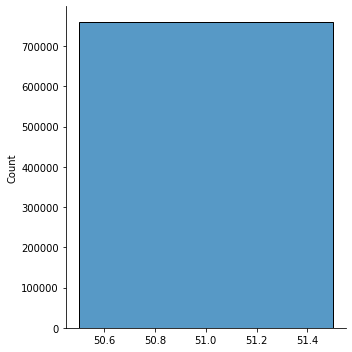

In [14]:
sns.displot(notes)

In [20]:
a = np.load("/content/drive/MyDrive/Major Project/paper/after_160/200/midi_200_epochs.npy").tolist()

In [21]:
a

[[[83.89446258544922, 0.3279820680618286, 0.08982580900192261],
  [69.25418853759766, 1.4125465154647827, -0.14631059765815735],
  [79.37300872802734, 0.5680069923400879, 0.07081031799316406],
  [79.16728973388672, 0.2343079000711441, 0.2903233766555786],
  [70.19158172607422, 0.1865670531988144, 0.13830068707466125],
  [68.29671478271484, 0.19062380492687225, 0.023371193557977676],
  [72.99311065673828, 0.12093256413936615, 0.2091338336467743],
  [59.65712356567383, -0.011702969670295715, -0.18497690558433533],
  [53.93990707397461, 0.2509017586708069, -0.3614679276943207],
  [43.47776412963867, 0.8418570756912231, 0.23776480555534363],
  [54.67216110229492, 0.3681154251098633, -0.3313159644603729],
  [66.44148254394531, 0.08715258538722992, -0.28243348002433777],
  [71.32708740234375, 0.10682322084903717, 0.18355980515480042],
  [59.56138229370117, 0.010925337672233582, -0.1896490752696991],
  [60.24962615966797, 0.07063286006450653, -0.32602670788764954],
  [63.11906433105469, 0.116